## Семинар 9: "LSTM"

ФИО:Белозёров Михаил Сергеевич

In [11]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

In [12]:
class LSTM (nn.Module):
    def __init__ (self, input_size, hidden_size, output_size):
        super (LSTM, self).__init__ ()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.sig = nn.Sigmoid ()
        self.tanh = nn.Tanh ()
        
        self.w_f_i = nn.Parameter (torch.Tensor (hidden_size, input_size))
        self.w_f_h = nn.Parameter (torch.Tensor (hidden_size, hidden_size))

        self.w_i_i = nn.Parameter (torch.Tensor (hidden_size, input_size))
        self.w_i_h = nn.Parameter (torch.Tensor (hidden_size, hidden_size))

        self.w_c_i = nn.Parameter (torch.Tensor (hidden_size, input_size))
        self.w_c_h = nn.Parameter (torch.Tensor (hidden_size, hidden_size))

        self.w_o_i = nn.Parameter (torch.Tensor (hidden_size, input_size))
        self.w_o_h = nn.Parameter (torch.Tensor (hidden_size, hidden_size))

        self.b_f_i = nn.Parameter (torch.Tensor (hidden_size))
        self.b_f_h = nn.Parameter (torch.Tensor (hidden_size))

        self.b_i_i = nn.Parameter (torch.Tensor (hidden_size))
        self.b_i_h = nn.Parameter (torch.Tensor (hidden_size))

        self.b_c_i = nn.Parameter (torch.Tensor (hidden_size))
        self.b_c_h = nn.Parameter (torch.Tensor (hidden_size))

        self.b_o_i = nn.Parameter (torch.Tensor (hidden_size))
        self.b_o_h = nn.Parameter (torch.Tensor (hidden_size))
        
    def forward (self, X, hidden=None, C=None):
        
        output = Variable (torch.Tensor (X.size (0), self.output_size))
        if hidden is None:
            hidden = Variable (torch.Tensor(self.hidden_size), requires_grad=False)
        if C is None:
            C = Variable (torch.Tensor(self.hidden_size), requires_grad=False)
            
        for i in xrange (X.size (0)):
            f_i     = self.sig (self.w_f_h * hidden + self.w_f_i * X[i] + self.b_f_h + self.b_f_i)
            input_i = self.sig (self.w_i_h * hidden + self.w_i_i * X[i] + self.b_i_i + self.b_i_h)
            C       = f_i * C + input_i * self.tanh (self.w_c_h * hidden + self.w_c_i * X[i] + self.b_c_i + self.b_c_h)
            output[i] = self.sig (self.w_o_h * hidden + self.w_o_i * X[i] + self.b_o_i + self.b_o_h)
            hidden    = output[i] * self.tanh (C)
            
        return output, hidden, C


## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM сделать решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

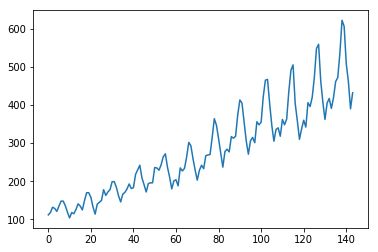

(96, 48)


In [21]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [25]:
trainX.shape

(94, 1, 1)

In [26]:
my_lstm = LSTM (trainX.shape[2], 10, trainX.shape[2])

loss = nn.MSELoss ()
optimizer = optim.Adam (my_lstm.parameters ())

epoch_num = 10

import sys

# for epoch in xrange (epoch_num):
h = None
c = None
for i in xrange (trainX.shape[0]):
    optimizer.zero_grad ()
    y, h, c = my_lstm (Variable (torch.Tensor(trainX[i]), requires_grad=False), h, c)

    t = Variable (torch.Tensor(trainY[i]), requires_grad=False)
    print t
    l = loss (y, t)
    l.backward (retain_graph=True)
    optimizer.step ()
    sys.stdout.write ("\repoch: {};loss: {}".format (epoch, l.data.mean ()))

RuntimeError: inconsistent tensor size, expected tensor [1] and src [10 x 10] to have the same number of elements, but got 1 and 100 elements respectively at /Users/soumith/miniconda2/conda-bld/pytorch_1503975203422/work/torch/lib/TH/generic/THTensorCopy.c:86

In [10]:
y_res = []
for i in xrange (trainX.shape[0]):
        y, h, c = my_lstm (Variable (torch.Tensor(trainX[i]), requires_grad=False), h, c)
        y_res.append (y.data.mean())

RuntimeError: inconsistent tensor size, expected r_ [10 x 10], t [10 x 10] and src [10 x 5] to have the same number of elements, but got 100, 100 and 50 elements respectively at /Users/soumith/miniconda2/conda-bld/pytorch_1503975203422/work/torch/lib/TH/generic/THTensorMath.c:887

In [ ]:
plt.plot (y_res)
plt.plot (trainY.reshape (trainY.shape[0], -1))

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: